# Police and Incidents Clean-up and Connecting Police Incidents and School Locations

In [74]:
import warnings
import pandas as pd
from pathlib import Path
import geopandas

## Extract and Inspect Data

In [75]:
# File Path to Police Incidents in Philadelphia from January 2024- July 2024
incidents_data_to_load = Path("data\incidents_part1_part2.csv")

# Read Police Incidents Data File and store into Pandas DataFrames
incidents_data = pd.read_csv(incidents_data_to_load)

# Check DataFrame was created
incidents_data.head()

,the_geom,cartodb_id,the_geom_webmercator,objectid,dc_dist,psa,dispatch_date_time,dispatch_date,dispatch_time,hour,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng
0,0101000020E6100000439FB8B153CC52C0B6D18416A7F9...,3097150,0101000020110F00007AD170B738EE5FC136FD1FB6DC88...,13965196,18,3,2024-02-02 16:30:00+00,2024-02-02,11:30:00,11.0,2.024180e+11,300 BLOCK S 34TH ST,600,Thefts,-75.192608,39.950412,39.950412,-75.192608
1,NaN,3097416,NaN,17545922,17,1,2024-06-15 12:10:00+00,2024-06-15,08:10:00,8.0,2.024170e+11,2100 BLOCK SOUTH ST,600,Thefts,NaN,NaN,NaN,NaN
2,NaN,3097550,NaN,13065664,5,1,2024-01-06 20:35:00+00,2024-01-06,15:35:00,15.0,2.024050e+11,300 BLOCK ROCHELLE AV,600,Thefts,NaN,NaN,NaN,NaN
3,NaN,3098085,NaN,15737696,3,3,2024-04-26 21:13:00+00,2024-04-26,17:13:00,17.0,2.024030e+11,1100 BLOCK ELLSWORTH ST,1100,Fraud,NaN,NaN,NaN,NaN
4,0101000020E6100000B10E2EBA48C452C015DB8B059101...,3098523,0101000020110F0000117C9F5A8FE05FC117D42E37A291...,14865984,15,2,2024-03-15 11:17:00+00,2024-03-15,07:17:00,7.0,2.024150e+11,5500 BLOCK TULIP ST,600,Thefts,-75.066939,40.012238,40.012238,-75.066939


In [26]:
# Inspect Incident Data
incidents_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85529 entries, 0 to 85528
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   the_geom              79988 non-null  object 
 1   cartodb_id            85529 non-null  int64  
 2   the_geom_webmercator  79940 non-null  object 
 3   objectid              85529 non-null  int64  
 4   dc_dist               85529 non-null  int64  
 5   psa                   85495 non-null  object 
 6   dispatch_date_time    85529 non-null  object 
 7   dispatch_date         85529 non-null  object 
 8   dispatch_time         85529 non-null  object 
 9   hour                  85527 non-null  float64
 10  dc_key                85529 non-null  float64
 11  location_block        85513 non-null  object 
 12  ucr_general           85529 non-null  int64  
 13  text_general_code     85529 non-null  object 
 14  point_x               79940 non-null  float64
 15  point_y            

## Review of keys for data file by referencing the Open Philly Data website
#### 'cartodb_id' is the unique identifier for the crime incident record.
#### 'dc_dist' is the code for the police district responsible for the area where the incident took place.
#### 'text_general_code' provides a textual description of the incident type.
#### 'ucr_general' provides a standardized crime code.
#### 'location' specifies the geographic location of the incident.
#### 'psa' is Police Service Area within the Police District.  There are multiple service areas within the same district.

In [46]:
# Find the number of incident types and crime codes for incidents

text_general_code_count=incidents_data['text_general_code'].nunique()
ucr_general_count=incidents_data['ucr_general'].nunique()
print("Number of unique general codes for incident type:", text_general_code_count)
print("Number of unique general ucr for incident type:", ucr_general_count)

Number of unique general codes for incident type: 31
Number of unique general ucr for incident type: 26


In [47]:
# Calculate the number of unique general codes and UCR codes for incident type
text_general_code_count = incidents_data['text_general_code'].nunique()
ucr_general_count = incidents_data['ucr_general'].nunique()

print("Number of unique general codes for incident type:", text_general_code_count)
print("Number of unique general UCR codes for incident type:", ucr_general_count)

# Group incidents by their UCR code and list them
ucr_incidents = incidents_data.groupby('ucr_general')['text_general_code'].unique()

# Convert the groupby object to a DataFrame for better readability
ucr_incidents_df = ucr_incidents.reset_index()
ucr_incidents_df.columns = ['UCR General Code', 'Incidents']

ucr_incidents_df


Number of unique general codes for incident type: 31
Number of unique general UCR codes for incident type: 26


,UCR General Code,Incidents
0,100,"[Homicide - Criminal, Homicide - Justifiable]"
1,200,[Rape]
2,300,"[Robbery Firearm, Robbery No Firearm]"
3,400,"[Aggravated Assault No Firearm, Aggravated Ass..."
4,500,"[Burglary Non-Residential, Burglary Residential]"
5,600,"[Thefts, Theft from Vehicle]"
6,700,[Motor Vehicle Theft]
7,800,[Other Assaults]
8,900,[Arson]
9,1000,[Forgery and Counterfeiting]


In [30]:
# Calculate the number of unique general codes and UCR codes for incident type
dc_dist_count = incidents_data['dc_dist'].nunique()
psa_count = incidents_data['psa'].nunique()
objectid_count= incidents_data['objectid'].nunique()
dc_key_count=incidents_data['dc_key'].nunique()

print("Number police districts responsible for the areas where the incidents took place:", dc_dist_count)
print("Number police service areas where the incidents took place:", psa_count)
print("Number object ids for incidents:", objectid_count)
print("Number dc_key_counts for incidents:", dc_key_count)


Number police districts responsible for the areas where the incidents took place: 22
Number police service areas where the incidents took place: 6
Number object ids for incidents: 85529
Number dc_key_counts for incidents: 85520


## Transforming Data

#### Duplicates: Although, there are duplicate 'dc_key's there is variation in the other data for the different unique 'object_id's. Because of this, the duplicate dc_keys for this dataset were not removed due to not knowing if they are actually duplicates.  Some of these smae rows are missing coordinate data and will be removed due to their lack of coordinates needed for analysiss. There is a small number compared to total dataset, so this should not impact analysis.    


In [49]:
# Identify duplicates based on 'dc_key' 
duplicates = incidents_data[incidents_data.duplicated(subset=['dc_key'], keep=False)]

print("Duplicates based on 'dc_key':")
duplicates
#duplicates.count()

Duplicates based on 'dc_key':


,the_geom,cartodb_id,the_geom_webmercator,objectid,dc_dist,psa,dispatch_date_time,dispatch_date,dispatch_time,hour,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng
19063,0101000020E610000008F53E9F52C952C0B36AC658DC00...,3178665,0101000020110F00001B96BE5E1EE95FC1AC6968E0D990...,18326613,25,4,2024-07-14 03:12:00+00,2024-07-13,23:12:00,23.0,2.024250e+11,3500 BLOCK N WARNOCK ST,400,Aggravated Assault Firearm,-75.145668,40.006724,40.006724,-75.145668
20439,0101000020E6100000CBBAA03A2DC352C0B7A5C464E005...,3180345,0101000020110F00008CA0BECDADDE5FC1A866C1066A96...,15265578,15,3,2024-04-08 18:39:00+00,2024-04-08,14:39:00,14.0,2.024150e+11,7400 BLOCK REVERE ST,400,Aggravated Assault Firearm,-75.049636,40.045910,40.045910,-75.049636
29540,0101000020E6100000F7BD76FEE7C952C0605B3FFDE7FA...,3191206,0101000020110F00002770E7171CEA5FC18153AE41408A...,18383386,6,1,2024-04-07 04:00:00+00,2024-04-07,00:00:00,9.0,2.024060e+11,900 BLOCK HAMILTON ST,100,Homicide - Criminal,-75.154785,39.960205,39.960205,-75.154785
32818,NaN,3197371,NaN,18383324,2,2,2024-05-21 04:00:00+00,2024-05-21,00:00:00,14.0,2.024020e+11,6000 BLOCK BINGHAM ST,100,Homicide - Criminal,NaN,NaN,NaN,NaN
32819,NaN,3197372,NaN,18383325,2,2,2024-05-21 04:00:00+00,2024-05-21,00:00:00,14.0,2.024020e+11,6000 BLOCK BINGHAM ST,100,Homicide - Criminal,NaN,NaN,NaN,NaN
33071,NaN,3197847,NaN,18383336,16,3,2024-04-25 04:00:00+00,2024-04-25,00:00:00,17.0,2.024160e+11,2500 BLOCK A ST,100,Homicide - Criminal,NaN,NaN,NaN,NaN
33329,NaN,3198336,NaN,18383347,22,4,2024-02-29 05:00:00+00,2024-02-29,00:00:00,23.0,2.024220e+11,3800 BLOCK MT PLEASANT AVE,100,Homicide - Criminal,NaN,NaN,NaN,NaN
33333,NaN,3198341,NaN,18383350,15,3,2024-04-09 04:00:00+00,2024-04-09,00:00:00,15.0,2.024150e+11,7400 BLOCK REVERE ST,100,Homicide - Criminal,NaN,NaN,NaN,NaN
33349,NaN,3198358,NaN,18383346,22,4,2024-02-29 05:00:00+00,2024-02-29,00:00:00,23.0,2.024220e+11,3800 BLOCK MT PLEASANT DR,100,Homicide - Criminal,NaN,NaN,NaN,NaN
33356,NaN,3198365,NaN,18383363,25,4,2024-07-14 04:00:00+00,2024-07-14,00:00:00,23.0,2.024250e+11,1000 BLOCK W VENANGO ST,100,Homicide - Criminal,NaN,NaN,NaN,NaN


### Changing data to DateTime to be able to analyze Crime Incidents over time

In [50]:
# Convert 'dispatch_date_time' to datetime format
incidents_data['dispatch_date_time'] = pd.to_datetime(incidents_data['dispatch_date_time'], errors='coerce')

# Convert 'dispatch_date' to datetime format (date only)
incidents_data['dispatch_date'] = pd.to_datetime(incidents_data['dispatch_date'], format='%Y-%m-%d', errors='coerce')

# Convert 'dispatch_time' to datetime format (time only)
incidents_data['dispatch_time'] = pd.to_datetime(incidents_data['dispatch_time'], format='%H:%M:%S', errors='coerce').dt.time

# Check the DataFrame to ensure the conversion
print(incidents_data[['dispatch_date_time', 'dispatch_date', 'dispatch_time']].head())

incidents_data.info()

         dispatch_date_time dispatch_date dispatch_time
0 2024-02-02 16:30:00+00:00    2024-02-02      11:30:00
1 2024-06-15 12:10:00+00:00    2024-06-15      08:10:00
2 2024-01-06 20:35:00+00:00    2024-01-06      15:35:00
3 2024-04-26 21:13:00+00:00    2024-04-26      17:13:00
4 2024-03-15 11:17:00+00:00    2024-03-15      07:17:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85529 entries, 0 to 85528
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   the_geom              79988 non-null  object             
 1   cartodb_id            85529 non-null  int64              
 2   the_geom_webmercator  79940 non-null  object             
 3   objectid              85529 non-null  int64              
 4   dc_dist               85529 non-null  int64              
 5   psa                   85495 non-null  object             
 6   dispatch_date_time    85529 non-null  datetime

### Creating a Combined Key of the District Number and Police Service Area Number:  
#### This will allow us to locate the specific location of the Police Service Area and use the Key to connect location of other data. 

In [51]:
# Creating the combined key
incidents_data['PSA_NUM'] = incidents_data['dc_dist'].astype(str) + incidents_data['psa'].astype(str)

incidents_data=incidents_data[incidents_data['PSA_NUM']!='77A']

incidents_data = incidents_data.reset_index(drop=True)

# Display the result
incidents_data


,the_geom,cartodb_id,the_geom_webmercator,objectid,dc_dist,psa,dispatch_date_time,dispatch_date,dispatch_time,hour,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng,PSA_NUM
0,0101000020E6100000439FB8B153CC52C0B6D18416A7F9...,3097150,0101000020110F00007AD170B738EE5FC136FD1FB6DC88...,13965196,18,3,2024-02-02 16:30:00+00:00,2024-02-02,11:30:00,11.0,2.024180e+11,300 BLOCK S 34TH ST,600,Thefts,-75.192608,39.950412,39.950412,-75.192608,183
1,NaN,3097416,NaN,17545922,17,1,2024-06-15 12:10:00+00:00,2024-06-15,08:10:00,8.0,2.024170e+11,2100 BLOCK SOUTH ST,600,Thefts,NaN,NaN,NaN,NaN,171
2,NaN,3097550,NaN,13065664,5,1,2024-01-06 20:35:00+00:00,2024-01-06,15:35:00,15.0,2.024050e+11,300 BLOCK ROCHELLE AV,600,Thefts,NaN,NaN,NaN,NaN,51
3,NaN,3098085,NaN,15737696,3,3,2024-04-26 21:13:00+00:00,2024-04-26,17:13:00,17.0,2.024030e+11,1100 BLOCK ELLSWORTH ST,1100,Fraud,NaN,NaN,NaN,NaN,33
4,0101000020E6100000B10E2EBA48C452C015DB8B059101...,3098523,0101000020110F0000117C9F5A8FE05FC117D42E37A291...,14865984,15,2,2024-03-15 11:17:00+00:00,2024-03-15,07:17:00,7.0,2.024150e+11,5500 BLOCK TULIP ST,600,Thefts,-75.066939,40.012238,40.012238,-75.066939,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84881,0101000020E6100000DC35D71F57C652C04C21A9E8BC00...,3261336,0101000020110F0000AFFB117E0DE45FC11A18C904B790...,16408002,24,1,2024-05-16 04:57:00+00:00,2024-05-16,00:57:00,0.0,2.024240e+11,3800 BLOCK CASTOR AV,2600,All Other Offenses,-75.099068,40.005765,40.005765,-75.099068,241
84882,0101000020E6100000DCB5C69862CB52C016DD593FA6FC...,3261337,0101000020110F0000656C34309FEC5FC134C3CDC62E8C...,16408889,22,4,2024-05-20 21:52:00+00:00,2024-05-20,17:52:00,17.0,2.024220e+11,2500 BLOCK W Girard Ave,700,Motor Vehicle Theft,-75.177893,39.973823,39.973823,-75.177893,224
84883,0101000020E61000006D15EDBF48C952C0E626073FB306...,3261338,0101000020110F0000E062D6990DE95FC1EB8DA2F65397...,16408466,35,3,2024-05-13 16:10:00+00:00,2024-05-13,12:10:00,12.0,2.024350e+11,6400 BLOCK N 16TH ST,700,Motor Vehicle Theft,-75.145065,40.052345,40.052345,-75.145065,353
84884,0101000020E6100000C5742156FFCC52C017693DD7D2F9...,3261339,0101000020110F000023DDA5445CEF5FC12437492F0D89...,16408899,18,3,2024-05-19 20:51:00+00:00,2024-05-19,16:51:00,16.0,2.024180e+11,S 40TH ST & SPRUCE ST,700,Motor Vehicle Theft,-75.203085,39.951747,39.951747,-75.203085,183


#### Creating a New Data Frame Removing Columns that are not needed and Rows with missing data

In [52]:
#Make a new data frame for Incident Information and Removing Columns and Rows with NaN

incidents_data_df = pd.DataFrame({
    'Incident_ID': incidents_data['objectid'],
    'District': incidents_data['dc_dist'],
    'Police_Service_Area': incidents_data['psa'], 
    'District_PSA': incidents_data['PSA_NUM'], 
    'Dispatch_Date_and_Time': incidents_data['dispatch_date_time'],
    'Dispatch_Date': incidents_data['dispatch_date'],
    'Dispatch_Time': incidents_data['dispatch_time'],      
    'Dispatch_Hour': incidents_data['hour'],
    'Location_Block': incidents_data['location_block'],
    'UCR_Code': incidents_data['ucr_general'],
    'General_Crime_Category': incidents_data['text_general_code']
})

incidents_data_df

,Incident_ID,District,Police_Service_Area,District_PSA,Dispatch_Date_and_Time,Dispatch_Date,Dispatch_Time,Dispatch_Hour,Location_Block,UCR_Code,General_Crime_Category
0,13965196,18,3,183,2024-02-02 16:30:00+00:00,2024-02-02,11:30:00,11.0,300 BLOCK S 34TH ST,600,Thefts
1,17545922,17,1,171,2024-06-15 12:10:00+00:00,2024-06-15,08:10:00,8.0,2100 BLOCK SOUTH ST,600,Thefts
2,13065664,5,1,51,2024-01-06 20:35:00+00:00,2024-01-06,15:35:00,15.0,300 BLOCK ROCHELLE AV,600,Thefts
3,15737696,3,3,33,2024-04-26 21:13:00+00:00,2024-04-26,17:13:00,17.0,1100 BLOCK ELLSWORTH ST,1100,Fraud
4,14865984,15,2,152,2024-03-15 11:17:00+00:00,2024-03-15,07:17:00,7.0,5500 BLOCK TULIP ST,600,Thefts
...,...,...,...,...,...,...,...,...,...,...,...
84881,16408002,24,1,241,2024-05-16 04:57:00+00:00,2024-05-16,00:57:00,0.0,3800 BLOCK CASTOR AV,2600,All Other Offenses
84882,16408889,22,4,224,2024-05-20 21:52:00+00:00,2024-05-20,17:52:00,17.0,2500 BLOCK W Girard Ave,700,Motor Vehicle Theft
84883,16408466,35,3,353,2024-05-13 16:10:00+00:00,2024-05-13,12:10:00,12.0,6400 BLOCK N 16TH ST,700,Motor Vehicle Theft
84884,16408899,18,3,183,2024-05-19 20:51:00+00:00,2024-05-19,16:51:00,16.0,S 40TH ST & SPRUCE ST,700,Motor Vehicle Theft


In [53]:
# First, drop rows with any NaN values
incidents_data_df = incidents_data_df.dropna(how='any')

# Then, drop rows where 'Not Available' is present in any column
incidents_data_df = incidents_data_df[~incidents_data_df.isin(['Not Available']).any(axis=1)]

columns_to_convert = ['Incident_ID',
    'District',
    'Police_Service_Area',
    'District_PSA',  
    'Dispatch_Date_and_Time',
    'Dispatch_Date',
    'Dispatch_Time',      
    'Dispatch_Hour',
    'Location_Block',
    'UCR_Code',
    'General_Crime_Category']

IncidentsTimePlace = incidents_data_df.copy()  # Copy the original DataFrame

IncidentsTimePlace

,Incident_ID,District,Police_Service_Area,District_PSA,Dispatch_Date_and_Time,Dispatch_Date,Dispatch_Time,Dispatch_Hour,Location_Block,UCR_Code,General_Crime_Category
0,13965196,18,3,183,2024-02-02 16:30:00+00:00,2024-02-02,11:30:00,11.0,300 BLOCK S 34TH ST,600,Thefts
1,17545922,17,1,171,2024-06-15 12:10:00+00:00,2024-06-15,08:10:00,8.0,2100 BLOCK SOUTH ST,600,Thefts
2,13065664,5,1,51,2024-01-06 20:35:00+00:00,2024-01-06,15:35:00,15.0,300 BLOCK ROCHELLE AV,600,Thefts
3,15737696,3,3,33,2024-04-26 21:13:00+00:00,2024-04-26,17:13:00,17.0,1100 BLOCK ELLSWORTH ST,1100,Fraud
4,14865984,15,2,152,2024-03-15 11:17:00+00:00,2024-03-15,07:17:00,7.0,5500 BLOCK TULIP ST,600,Thefts
...,...,...,...,...,...,...,...,...,...,...,...
84881,16408002,24,1,241,2024-05-16 04:57:00+00:00,2024-05-16,00:57:00,0.0,3800 BLOCK CASTOR AV,2600,All Other Offenses
84882,16408889,22,4,224,2024-05-20 21:52:00+00:00,2024-05-20,17:52:00,17.0,2500 BLOCK W Girard Ave,700,Motor Vehicle Theft
84883,16408466,35,3,353,2024-05-13 16:10:00+00:00,2024-05-13,12:10:00,12.0,6400 BLOCK N 16TH ST,700,Motor Vehicle Theft
84884,16408899,18,3,183,2024-05-19 20:51:00+00:00,2024-05-19,16:51:00,16.0,S 40TH ST & SPRUCE ST,700,Motor Vehicle Theft


#### Creating a DataFrame to just show the District and PSA for future use

In [54]:
district_psa_df=pd.DataFrame({
    'District_PSA':IncidentsTimePlace['District_PSA'],
    'District':IncidentsTimePlace['District'],
    'Police_Service_Area':IncidentsTimePlace['Police_Service_Area']
})

# Sort by 'District' first and then by 'Police Service Area'
district_psa_df = district_psa_df.sort_values(by=['District', 'Police_Service_Area'])

# Reset index if you want a clean index
district_psa_df = district_psa_df.reset_index(drop=True)

district_psa_df

,District_PSA,District,Police_Service_Area
0,11,1,1
1,11,1,1
2,11,1,1
3,11,1,1
4,11,1,1
...,...,...,...
84829,393,39,3
84830,393,39,3
84831,393,39,3
84832,393,39,3


In [55]:
# Remove duplicates based on a specific column or combination of columns
Districts = district_psa_df.drop_duplicates(subset=['District_PSA'], keep='first')

# Optionally, reset the index if needed
Districts.reset_index(drop=True, inplace=True)

# Save the cleaned DataFrame to a new CSV file

output_file_path= 'Districts.csv'

# Save the DataFrame to a CSV file
Districts.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")
Districts

DataFrame saved to Districts.csv


,District_PSA,District,Police_Service_Area
0,11,1,1
1,12,1,2
2,21,2,1
3,22,2,2
4,23,2,3
...,...,...,...
63,352,35,2
64,353,35,3
65,391,39,1
66,392,39,2


### Creating Crime Categories for analysis with grouped data

In [56]:
incident_code_df=pd.DataFrame({
    'UCR_Code':incidents_data['ucr_general'],
    'General_Crime_Category':incidents_data['text_general_code']
})

# Sort by 'UCR Code' first and then by 'General Crime Category'
incident_code_df = incident_code_df.sort_values(by=['UCR_Code'])

# Reset index if you want a clean index
incident_code_df = incident_code_df.reset_index(drop=True)

incident_code_df



,UCR_Code,General_Crime_Category
0,100,Homicide - Criminal
1,100,Homicide - Criminal
2,100,Homicide - Criminal
3,100,Homicide - Criminal
4,100,Homicide - Criminal
...,...,...
84881,2600,All Other Offenses
84882,2600,All Other Offenses
84883,2600,All Other Offenses
84884,2600,All Other Offenses


In [57]:
# Define the crime groups
group_mapping = {
    'Violent Crimes': ['Homicide - Criminal', 'Homicide - Justifiable', 'Rape', 'Robbery No Firearm', 'Robbery Firearm', 'Aggravated Assault Firearm', 'Aggravated Assault No Firearm', 'Other Assaults'],
    'Property Crimes': ['Burglary Residential', 'Burglary Non-Residential', 'Thefts', 'Theft from Vehicle', 'Motor Vehicle Theft', 'Arson', 'Forgery and Counterfeiting', 'Receiving Stolen Property', 'Vandalism/Criminal Mischief'],
    'Public Order Crimes': ['Disorderly Conduct', 'Vagrancy/Loitering', 'Public Drunkenness', 'Liquor Law Violations', 'DRIVING UNDER THE INFLUENCE'],
    'Drug and Vice Crimes': ['Prostitution and Commercialized Vice', 'Narcotic / Drug Law Violations', 'Other Sex Offenses (Not Commercialized)', 'Gambling Violations'],
    'Other Crimes': ['Offenses Against Family and Children', 'Fraud', 'Embezzlement', 'Weapon Violations', 'All Other Offenses']
}

# Reverse the mapping to map each crime category to its group
crime_to_group = {crime: group for group, crimes in group_mapping.items() for crime in crimes}

# Create a new column for the crime group
IncidentsTimePlace['Crime_Group'] = IncidentsTimePlace['General_Crime_Category'].map(crime_to_group)

IncidentsTimePlace

,Incident_ID,District,Police_Service_Area,District_PSA,Dispatch_Date_and_Time,Dispatch_Date,Dispatch_Time,Dispatch_Hour,Location_Block,UCR_Code,General_Crime_Category,Crime_Group
0,13965196,18,3,183,2024-02-02 16:30:00+00:00,2024-02-02,11:30:00,11.0,300 BLOCK S 34TH ST,600,Thefts,Property Crimes
1,17545922,17,1,171,2024-06-15 12:10:00+00:00,2024-06-15,08:10:00,8.0,2100 BLOCK SOUTH ST,600,Thefts,Property Crimes
2,13065664,5,1,51,2024-01-06 20:35:00+00:00,2024-01-06,15:35:00,15.0,300 BLOCK ROCHELLE AV,600,Thefts,Property Crimes
3,15737696,3,3,33,2024-04-26 21:13:00+00:00,2024-04-26,17:13:00,17.0,1100 BLOCK ELLSWORTH ST,1100,Fraud,Other Crimes
4,14865984,15,2,152,2024-03-15 11:17:00+00:00,2024-03-15,07:17:00,7.0,5500 BLOCK TULIP ST,600,Thefts,Property Crimes
...,...,...,...,...,...,...,...,...,...,...,...,...
84881,16408002,24,1,241,2024-05-16 04:57:00+00:00,2024-05-16,00:57:00,0.0,3800 BLOCK CASTOR AV,2600,All Other Offenses,Other Crimes
84882,16408889,22,4,224,2024-05-20 21:52:00+00:00,2024-05-20,17:52:00,17.0,2500 BLOCK W Girard Ave,700,Motor Vehicle Theft,Property Crimes
84883,16408466,35,3,353,2024-05-13 16:10:00+00:00,2024-05-13,12:10:00,12.0,6400 BLOCK N 16TH ST,700,Motor Vehicle Theft,Property Crimes
84884,16408899,18,3,183,2024-05-19 20:51:00+00:00,2024-05-19,16:51:00,16.0,S 40TH ST & SPRUCE ST,700,Motor Vehicle Theft,Property Crimes


#### IncidentsTimePlace file as output to be used in DataBase

In [58]:
# Make an output for the new dataset
output_file_path = 'IncidentsTimePlace.csv'

# Save the DataFrame to a CSV file
IncidentsTimePlace.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

DataFrame saved to IncidentsTimePlace.csv


#### Incidents file as output to be used in DataBase

In [59]:
# Group by 'UCR Code' and aggregate unique values of 'General Crime Category' and 'Crime Group'
Incidents = IncidentsTimePlace.groupby('UCR_Code').agg({'General_Crime_Category': lambda x: x.unique(), 'Crime_Group': lambda x: x.unique()})

# Convert the series to a DataFrame
Incidents= Incidents.reset_index()

# Make an output for the new dataset
output_file_path = 'Incidents.csv'

Incidents.to_csv(output_file_path, index=False)

Incidents

,UCR_Code,General_Crime_Category,Crime_Group
0,100,"[Homicide - Criminal, Homicide - Justifiable]",[Violent Crimes]
1,200,[Rape],[Violent Crimes]
2,300,"[Robbery Firearm, Robbery No Firearm]",[Violent Crimes]
3,400,"[Aggravated Assault No Firearm, Aggravated Ass...",[Violent Crimes]
4,500,"[Burglary Non-Residential, Burglary Residential]",[Property Crimes]
5,600,"[Thefts, Theft from Vehicle]",[Property Crimes]
6,700,[Motor Vehicle Theft],[Property Crimes]
7,800,[Other Assaults],[Violent Crimes]
8,900,[Arson],[Property Crimes]
9,1000,[Forgery and Counterfeiting],[Property Crimes]


### Connecting the Police Service Area (PSA) coordinates which are polygons to the location of schools coordinate points
#### Two GeoJson Files Extracted: Philadelphia Schools Locations and Boundaries of the Police Services Areas in Philadelphia

In [76]:
import geopandas as gpd
from shapely.geometry import Point

# Load school locations
school_gdf = gpd.read_file('data\Schools.geojson')

# Load PSA boundaries
psa_gdf = gpd.read_file('data\Boundaries_PSA.geojson')

# Ensure both GeoDataFrames are in the same CRS
school_gdf = school_gdf.to_crs(epsg=4326)
psa_gdf = psa_gdf.to_crs(epsg=4326)

# Perform a spatial join to find which PSA polygon each school is in
school_with_psa = gpd.sjoin(school_gdf, psa_gdf, how='left', op='within')

# Extract relevant PSA and district information
school_with_psa['PSA_NUM'] = school_with_psa['PSA_NUM']
school_with_psa['DISTRICT'] = school_with_psa['DISTRICT__']

# Save the result to a new file or use it as needed
school_with_psa.to_file('schools_with_psa_info.geojson', driver='GeoJSON')

school_with_psa

c:\Users\ElizabethVandergrift\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,OBJECTID_left,AUN,SCHOOL_NUM,LOCATION_ID,SCHOOL_NAME,SCHOOL_NAME_LABEL,STREET_ADDRESS,ZIP_CODE,PHONE_NUMBER,ACTIVE,...,PSACOV_,PSACOV_ID,ID,DISTRICT__,PSA_NUM,OLD_SECTOR,DESCRIPT,Shape__Area,Shape__Length,DISTRICT
0,1,226519902.0,NaN,None,WEST CATHOLIC PREPARATORY HIGH SCHOOL,WEST PHILADELPHIA CATHOLIC HIGH SCHOOL,4501-17 CHESTNUT ST,19139,(215) 386-2244,O,...,None,None,40,18,183,"A,B,C,D,E,F,J",,8.544550e+06,13652.470162,18
1,2,226519382.0,NaN,None,ST THOMAS AQUINAS SCHOOL,ST THOMAS AQUINAS SCHOOL,1616 S 17TH ST,19145,(215) 334-0878,O,...,None,None,37,17,173,"A,B,D,E,I,O",,2.392552e+06,6409.564054,17
2,3,226519222.0,NaN,None,ST RAYMOND OF PENAFORT SCHOOL,ST RAYMOND SCHOOL,1330 VERNON RD,19150,(215) 548-1919,O,...,None,None,26,14,141,"A,C,F,K,N,Q,Y",,1.172253e+07,15338.858275,14
3,4,226519422.0,NaN,None,BLESSED TRINITY REGIONAL CATHOLIC SCHOOL,BLESSED TRINITY REGIONAL CATHOLIC SCHOOL,3033 LEVICK ST,19149,(215) 338-9797,O,...,None,None,31,15,152,"I,J,K,L,M",Unruh to Bridge - Roosevelt to Delaware,1.473769e+07,17143.738939,15
4,5,226519142.0,NaN,None,ST PETER THE APOSTLE SCHOOL,ST PETER THE APOSTLE SCHOOL,1009 N 5TH ST,19123,(215) 922-5958,O,...,None,None,49,26,262,"G,H,I,L,M,N",Norris St to Poplar St - Front St to 10th St,4.176330e+06,8352.638368,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,487,NaN,NaN,8890,ONE BRIGHT RAY-SIMPSON CAMPUS,ONE BRIGHT RAY - SIMPSON EVENING,1142 E ERIE AVE,19124,(215) 744-6000,None,...,None,None,45,24,241,"H,J,K,O,N",Alleghney to Wyoming/Frkfrd Crk-Aramingo to G St,7.761864e+06,13180.364347,24
487,488,133513315.0,8149.0,3406,JOHN B STETSON MIDDLE SCHOOL,JOHN B STETSON MIDDLE SCHOOL CONTINUATION ACADEMY,3200 B ST,19134,(215) 400-9150,None,...,None,None,65,25,253,,,4.515468e+06,9991.527244,25
488,489,NaN,NaN,None,None,WISSAHICKON CHARTER SCHOOL,815 E WASHINGTON LN,19138,(267) 774-4370,None,...,None,None,26,14,141,"A,C,F,K,N,Q,Y",,1.172253e+07,15338.858275,14
489,490,NaN,NaN,None,EXCEL ACADEMY CENTRAL,EXCEL ACADEMY CENTRAL,201 E OLNEY AVE,19120,None,None,...,None,None,51,35,351,"B,C,E,F",,1.013991e+07,14663.941899,35


In [61]:
school_with_psa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 491 entries, 0 to 490
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   OBJECTID_left      491 non-null    int64   
 1   AUN                451 non-null    float64 
 2   SCHOOL_NUM         286 non-null    float64 
 3   LOCATION_ID        328 non-null    object  
 4   SCHOOL_NAME        483 non-null    object  
 5   SCHOOL_NAME_LABEL  491 non-null    object  
 6   STREET_ADDRESS     491 non-null    object  
 7   ZIP_CODE           491 non-null    object  
 8   PHONE_NUMBER       490 non-null    object  
 9   ACTIVE             131 non-null    object  
 10  GRADE_LEVEL        490 non-null    object  
 11  GRADE_ORG          491 non-null    object  
 12  ENROLLMENT         329 non-null    float64 
 13  TYPE               491 non-null    int64   
 14  TYPE_SPECIFIC      491 non-null    object  
 15  geometry           491 non-null    geometry
 16  index

In [65]:
# Rename LOCATION_ID to school_id if not already done
school_with_psa = school_with_psa.rename(columns={'LOCATION_ID': 'school_id'})

# Include the desired columns
columns_schools_list = [
    'school_id',
    'SCHOOL_NAME',
    'SCHOOL_NAME_LABEL',
    'TYPE',
    'TYPE_SPECIFIC',
]

# Select only the desired columns
School_List = school_with_psa[columns_schools_list]

# Drop rows where 'school_id' is None or NaN
School_List = School_List[School_List['school_id'].notnull() & (School_List['school_id'] != None)]

# Reset index if you want a clean index
School_List = School_List.reset_index(drop=True)

# Check the result
School_List


,school_id,SCHOOL_NAME,SCHOOL_NAME_LABEL,TYPE,TYPE_SPECIFIC
0,2670,CONSTITUTION HIGH SCHOOL,CONSTITUTION HIGH SCHOOL,1,DISTRICT
1,5230,"CONWELL, RUSSELL MIDDLE SCHOOL",RUSSELL H. CONWELL SCHOOL,1,DISTRICT
2,7100,"COOKE, JAY ELEMENTARY SCHOOL",JAY COOKE SCHOOL,1,DISTRICT
3,6410,COOK-WISSAHICKON SCHOOL,COOK-WISSAHICKON SCHOOL,1,DISTRICT
4,5470,"CRAMP, WILLIAM SCHOOL",WILLIAM CRAMP SCHOOL,1,DISTRICT
...,...,...,...,...,...
323,3362,WISSAHICKON CHARTER SCHOOL,WISSAHICKON CHARTER SCHOOL,2,CHARTER
324,8130\r\n,NORTHEAST COMMUNITY PROPEL ACADEMY\r\n,NORTHEAST COMMUNITY PROPEL ACADEMY,1,DISTRICT
325,3414,OLNEY HIGH SCHOOL,OLNEY HIGH SCHOOL CONTINUATION ACADEMY,1,CONTRACTED
326,8890,ONE BRIGHT RAY-SIMPSON CAMPUS,ONE BRIGHT RAY - SIMPSON EVENING,1,CONTRACTED


In [ ]:
# Identify duplicates based on 'dc_key' 
duplicates = School_List[School_List.duplicated(subset=['school_id'], keep=False)]

print("Duplicates based on 'school_id':")
duplicates.count()
duplicates


Duplicates based on 'school_id':


,school_id,SCHOOL_NAME,SCHOOL_NAME_LABEL,TYPE,TYPE_SPECIFIC


In [ ]:
# Remove duplicates based on a specific column or combination of columns
School_List = School_List.drop_duplicates(subset=['school_id'], keep='first')

# Optionally, reset the index if needed
School_List.reset_index(drop=True, inplace=True)

# Save the cleaned DataFrame to a new CSV file

output_file_path= 'School_List.csv'

# Save the DataFrame to a CSV file
School_List.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")


DataFrame saved to School_List.csv


In [ ]:
school_with_psa.columns

Index(['OBJECTID_left', 'AUN', 'SCHOOL_NUM', 'school_id', 'SCHOOL_NAME',
       'SCHOOL_NAME_LABEL', 'STREET_ADDRESS', 'ZIP_CODE', 'PHONE_NUMBER',
       'ACTIVE', 'GRADE_LEVEL', 'GRADE_ORG', 'ENROLLMENT', 'TYPE',
       'TYPE_SPECIFIC', 'geometry', 'index_right', 'OBJECTID_right', 'AREA',
       'PERIMETER', 'PSACOV_', 'PSACOV_ID', 'ID', 'DISTRICT__', 'PSA_NUM',
       'OLD_SECTOR', 'DESCRIPT', 'Shape__Area', 'Shape__Length', 'DISTRICT'],
      dtype='object')

### Creating a School Location DataFrame showing its locaiton in a specific Police Service Area and Exporting the file for use in database 

In [ ]:
# Rename the specified columns
school_with_psa = school_with_psa.rename(columns={'OBJECTID_left': 'OBJECTID', 'LOCATION_ID': 'school_id', 'DISTRICT': 'District', 'PSA_NUM':'District_PSA'})

# List of columns to include, including the geometry column
columns_schools_with_geometry = [
    'OBJECTID',
    'school_id',
    'SCHOOL_NAME',
    'SCHOOL_NAME_LABEL',
    'STREET_ADDRESS',
    'ZIP_CODE',
    'PHONE_NUMBER',
    'GRADE_LEVEL',
    'GRADE_ORG',
    'TYPE',
    'TYPE_SPECIFIC',
    'geometry',  
    'District', 
    'District_PSA'
]

# Select only the specified columns
new_geo_schools_df = school_with_psa[columns_schools_with_geometry]

# Drop rows where 'school_id' is None
new_geo_schools_df = new_geo_schools_df[new_geo_schools_df['school_id'].notna()]

# Drop rows with any NaN values
new_geo_schools_df = new_geo_schools_df.dropna(how='any')

# Reset index for a clean index
new_geo_schools_df = new_geo_schools_df.reset_index(drop=True)

# Define the output file path
output_file_path = 'new_geo_schools_df.csv'

# Save the DataFrame to a CSV file
new_geo_schools_df.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

new_geo_schools_df

DataFrame saved to new_geo_schools_df.csv


,OBJECTID,school_id,SCHOOL_NAME,SCHOOL_NAME_LABEL,STREET_ADDRESS,ZIP_CODE,PHONE_NUMBER,GRADE_LEVEL,GRADE_ORG,TYPE,TYPE_SPECIFIC,geometry,District,District_PSA
0,70,2670,CONSTITUTION HIGH SCHOOL,CONSTITUTION HIGH SCHOOL,18 S 7TH ST,19106,(215) 400-7850,HIGH SCHOOL,9-12,1,DISTRICT,POINT (-75.15234 39.95025),09,095
1,71,5230,"CONWELL, RUSSELL MIDDLE SCHOOL",RUSSELL H. CONWELL SCHOOL,1849 E CLEARFIELD ST,19134,(215) 400-7210,MIDDLE SCHOOL,5-8,1,DISTRICT,POINT (-75.11482 39.99442),24,242
2,72,7100,"COOKE, JAY ELEMENTARY SCHOOL",JAY COOKE SCHOOL,1300 W LOUDON ST,19141,(215) 400-8330,ELEMENTARY/MIDDLE,K-8,1,DISTRICT,POINT (-75.14607 40.02553),35,352
3,73,6410,COOK-WISSAHICKON SCHOOL,COOK-WISSAHICKON SCHOOL,201 E SALAIGNAC ST,19128,(215) 400-3430,ELEMENTARY/MIDDLE,K-8,1,DISTRICT,POINT (-75.20680 40.02247),05,051
4,74,5470,"CRAMP, WILLIAM SCHOOL",WILLIAM CRAMP SCHOOL,3449 N MASCHER ST,19140,(215) 400-3860,ELEMENTARY SCHOOL,K-5,1,DISTRICT,POINT (-75.12994 40.00263),25,253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,466,3357,WEST PHILADELPHIA ACHIEVEMENT,WEST PHILADELPHIA ACHIEVEMENT CHARTER SCHOOL,6701 CALLOWHILL ST,19151,(215) 476-6471,ELEMENTARY SCHOOL,K-5,2,CHARTER,POINT (-75.25411 39.97067),19,191
323,467,3362,WISSAHICKON CHARTER SCHOOL,WISSAHICKON CHARTER SCHOOL,4700 WISSAHICKON AVE,19144,(267) 338-1020,ELEMENTARY/MIDDLE,K-8,2,CHARTER,POINT (-75.17259 40.01563),39,391
324,468,8130\r\n,NORTHEAST COMMUNITY PROPEL ACADEMY\r\n,NORTHEAST COMMUNITY PROPEL ACADEMY,7500 ROWLAND AVE,19136,(215) 400-8350,ELEMENTARY/MIDDLE,K-8,1,DISTRICT,POINT (-75.03999 40.04355),15,153
325,486,3414,OLNEY HIGH SCHOOL,OLNEY HIGH SCHOOL CONTINUATION ACADEMY,100 W DUNCANNON AVE,19120,(215) 400-9140,HIGH SCHOOL,9-12,1,CONTRACTED,POINT (-75.12381 40.02877),35,352


In [ ]:
# Read the GeoJSON file into a GeoDataFrame
geo_police_df = gpd.read_file('Police_Stations.geojson')

# List of columns to drop
columns_to_drop = ['geometry', 'RULEID']

# Drop the specified columns
police_loc_df = geo_police_df.drop(columns=columns_to_drop)

# Print the 

police_loc_df


# Make an output for the new dataset
output_file_path= 'police_loc_df.csv'


# Save the DataFrame to a CSV file
police_loc_df.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")


DataFrame saved to police_loc_df.csv


In [ ]:
geo_police_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   OBJECTID          24 non-null     int64   
 1   DISTRICT_NUMBER   24 non-null     int64   
 2   LOCATION          24 non-null     object  
 3   TELEPHONE_NUMBER  24 non-null     object  
 4   RULEID            24 non-null     object  
 5   geometry          24 non-null     geometry
dtypes: geometry(1), int64(2), object(3)
memory usage: 1.3+ KB


In [ ]:
geo_police_df

,OBJECTID,DISTRICT_NUMBER,LOCATION,TELEPHONE_NUMBER,RULEID,geometry
0,1,7,Bustleton Ave & Bowler St,686-3070,Rule_1,POINT (-75.03270 40.09098)
1,2,14,Haines St & Germantown Ave,686-3140,Rule_1,POINT (-75.17700 40.03843)
2,3,8,Academy Rd & Red Lion Rd,686-3080,Rule_1,POINT (-74.99730 40.08011)
3,4,2,Harbison Ave & Levick St,686-3020,Rule_1,POINT (-75.06325 40.03149)
4,5,35,N Broad St & Champlost St,686-3350,Rule_1,POINT (-75.14365 40.04450)
5,6,15,Harbison Ave & Levick St,686-3150,Rule_1,POINT (-75.06325 40.03149)
6,7,5,Ridge Ave & Cinnaminson St,686-3050,Rule_1,POINT (-75.22440 40.04020)
7,8,39,22nd St & Hunting Park Ave,686-3390,Rule_1,POINT (-75.16425 40.01090)
8,9,25,3901 Whitaker Ave,686-3250,Rule_1,POINT (-75.12249 40.00874)
9,10,22,17th St & Montgomery Ave,686-3220,Rule_1,POINT (-75.16240 39.98079)


In [ ]:

zip_codes = [
    19115,
    19144,
    19114,
    19149,
    19141,
    19149,
    19128,
    19140,
    19124,
    19121,
    19124,
    19125,
    19151,
    19104,
    19130,
    19107,
    19143,
    19146,
    19147,
    19142,
    19145,
    19130,
    19106,
    19104
]

# Step 3: Add the 'Zip Code' column to the DataFrame
geo_police_df['Zip Code'] = zip_codes[:len(geo_police_df)]  # Ensure the length matches

PoliceLocation=pd.DataFrame({ 
    'Police_Location_ID': geo_police_df['OBJECTID'],
    'District': geo_police_df['DISTRICT_NUMBER'],
    'Location': geo_police_df['LOCATION'],  
    'ZIP_CODE': geo_police_df['Zip Code'],
    'Telephone_Number': geo_police_df['TELEPHONE_NUMBER'],
    'Geometry': geo_police_df['geometry']
})

PoliceLocation

# Make an output for the new dataset
output_file_path= 'PoliceLocation.csv'


# Save the DataFrame to a CSV file
PoliceLocation.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")
    

DataFrame saved to PoliceLocation.csv


### Creating a Police "Districts" DataFrame and Exporting for Use in Database

In [ ]:
Districts = pd.merge( Districts, PoliceLocation, on='District', how='left')

Districts

,District_PSA,District,Police_Service_Area,Police_Location_ID,Location,ZIP_CODE,Telephone_Number,Geometry
0,11,1,1,21,24th St & Wolf St,19145,686-3010,POINT (-75.18693 39.92407)
1,12,1,2,21,24th St & Wolf St,19145,686-3010,POINT (-75.18693 39.92407)
2,21,2,1,4,Harbison Ave & Levick St,19149,686-3020,POINT (-75.06325 40.03149)
3,22,2,2,4,Harbison Ave & Levick St,19149,686-3020,POINT (-75.06325 40.03149)
4,23,2,3,4,Harbison Ave & Levick St,19149,686-3020,POINT (-75.06325 40.03149)
...,...,...,...,...,...,...,...,...
63,352,35,2,5,N Broad St & Champlost St,19141,686-3350,POINT (-75.14365 40.04450)
64,353,35,3,5,N Broad St & Champlost St,19141,686-3350,POINT (-75.14365 40.04450)
65,391,39,1,8,22nd St & Hunting Park Ave,19140,686-3390,POINT (-75.16425 40.01090)
66,392,39,2,8,22nd St & Hunting Park Ave,19140,686-3390,POINT (-75.16425 40.01090)


In [ ]:
# Make an output for the new dataset
output_file_path= 'Districts.csv'


# Save the DataFrame to a CSV file
Districts.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")


DataFrame saved to Districts.csv


In [78]:
# File Path to Total Crimes and Elementray School Data for Police Service Area
comparison_data_to_load = Path("SQL Outputs\Total_Crimes_ES_PSA.csv")

# Read Police Incidents Data File and store into Pandas DataFrames
comparison_data = pd.read_csv(comparison_data_to_load)

# Check DataFrame was created
comparison_data.head()

,District_PSA,Average_ELA_Proficiency_3_to_8,Average_Math_Proficiency_3_to_8,Average_Percent_Attending_90,Total_Crimes
0,11,34.70,28.0,54.2,1029
1,121,22.80,14.2,57.6,1211
2,122,22.35,12.6,59.7,809
3,123,24.60,8.3,59.0,1816
4,141,27.05,14.2,59.7,1717


In [69]:
# Calculate correlation matrix
correlation_matrix = comparison_data.corr()
correlation_matrix

,District_PSA,Average_ELA_Proficiency_3_to_8,Average_Math_Proficiency_3_to_8,Average_Percent_Attending_90,Total_Crimes
District_PSA,1.000000,-0.405626,-0.443798,-0.324194,0.026480
Average_ELA_Proficiency_3_to_8,-0.405626,1.000000,0.954116,0.785444,-0.410879
Average_Math_Proficiency_3_to_8,-0.443798,0.954116,1.000000,0.760567,-0.388501
Average_Percent_Attending_90,-0.324194,0.785444,0.760567,1.000000,-0.466778
Total_Crimes,0.026480,-0.410879,-0.388501,-0.466778,1.000000


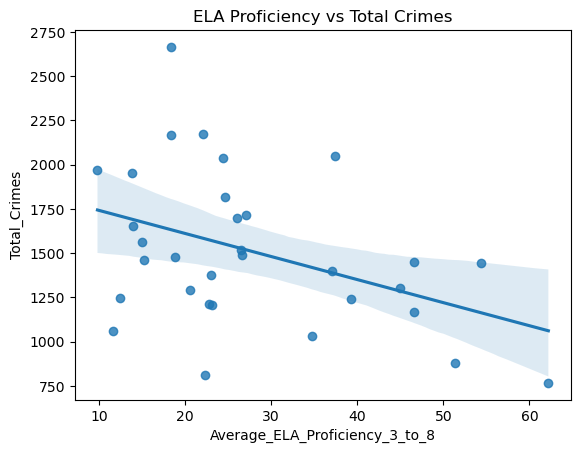

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the relationship between ELA Proficiency and Total Crimes
sns.regplot(x='Average_ELA_Proficiency_3_to_8', y='Total_Crimes', data=comparison_data)
plt.title('ELA Proficiency vs Total Crimes')
plt.show()
